# Grundlegende Eigenschaften von qubits

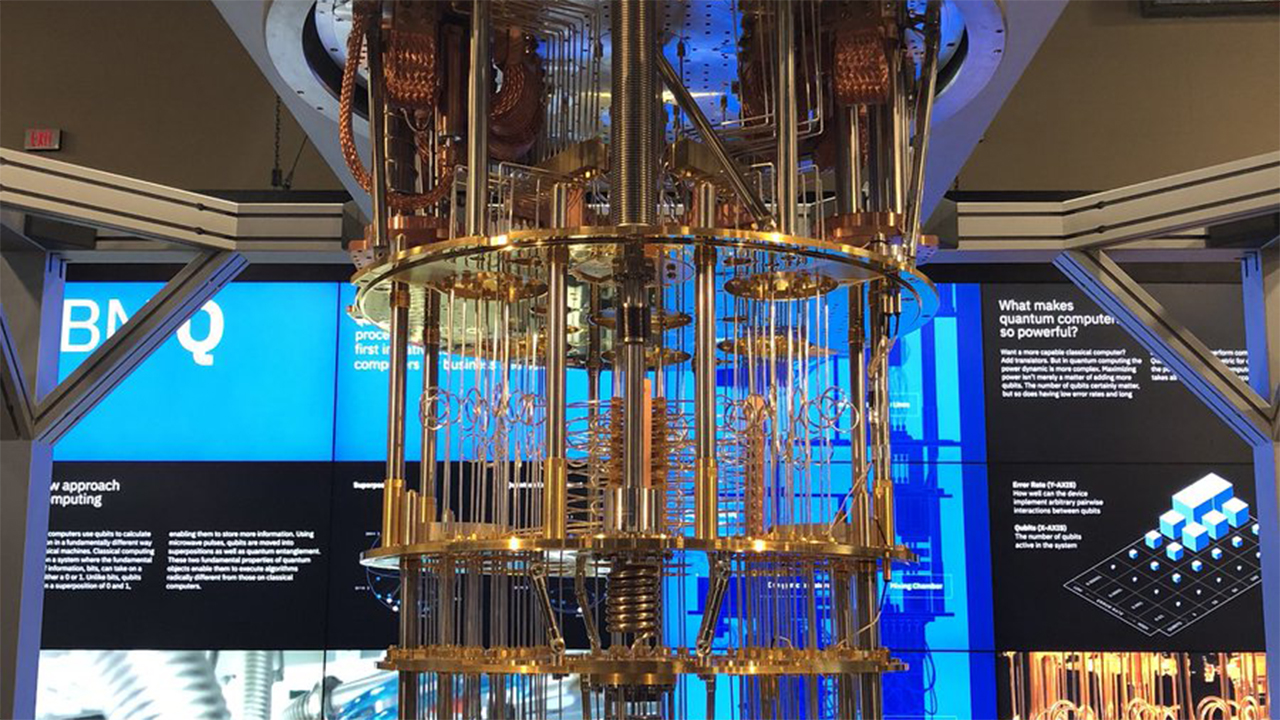

In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram

## Physik und Quantum Supremacy

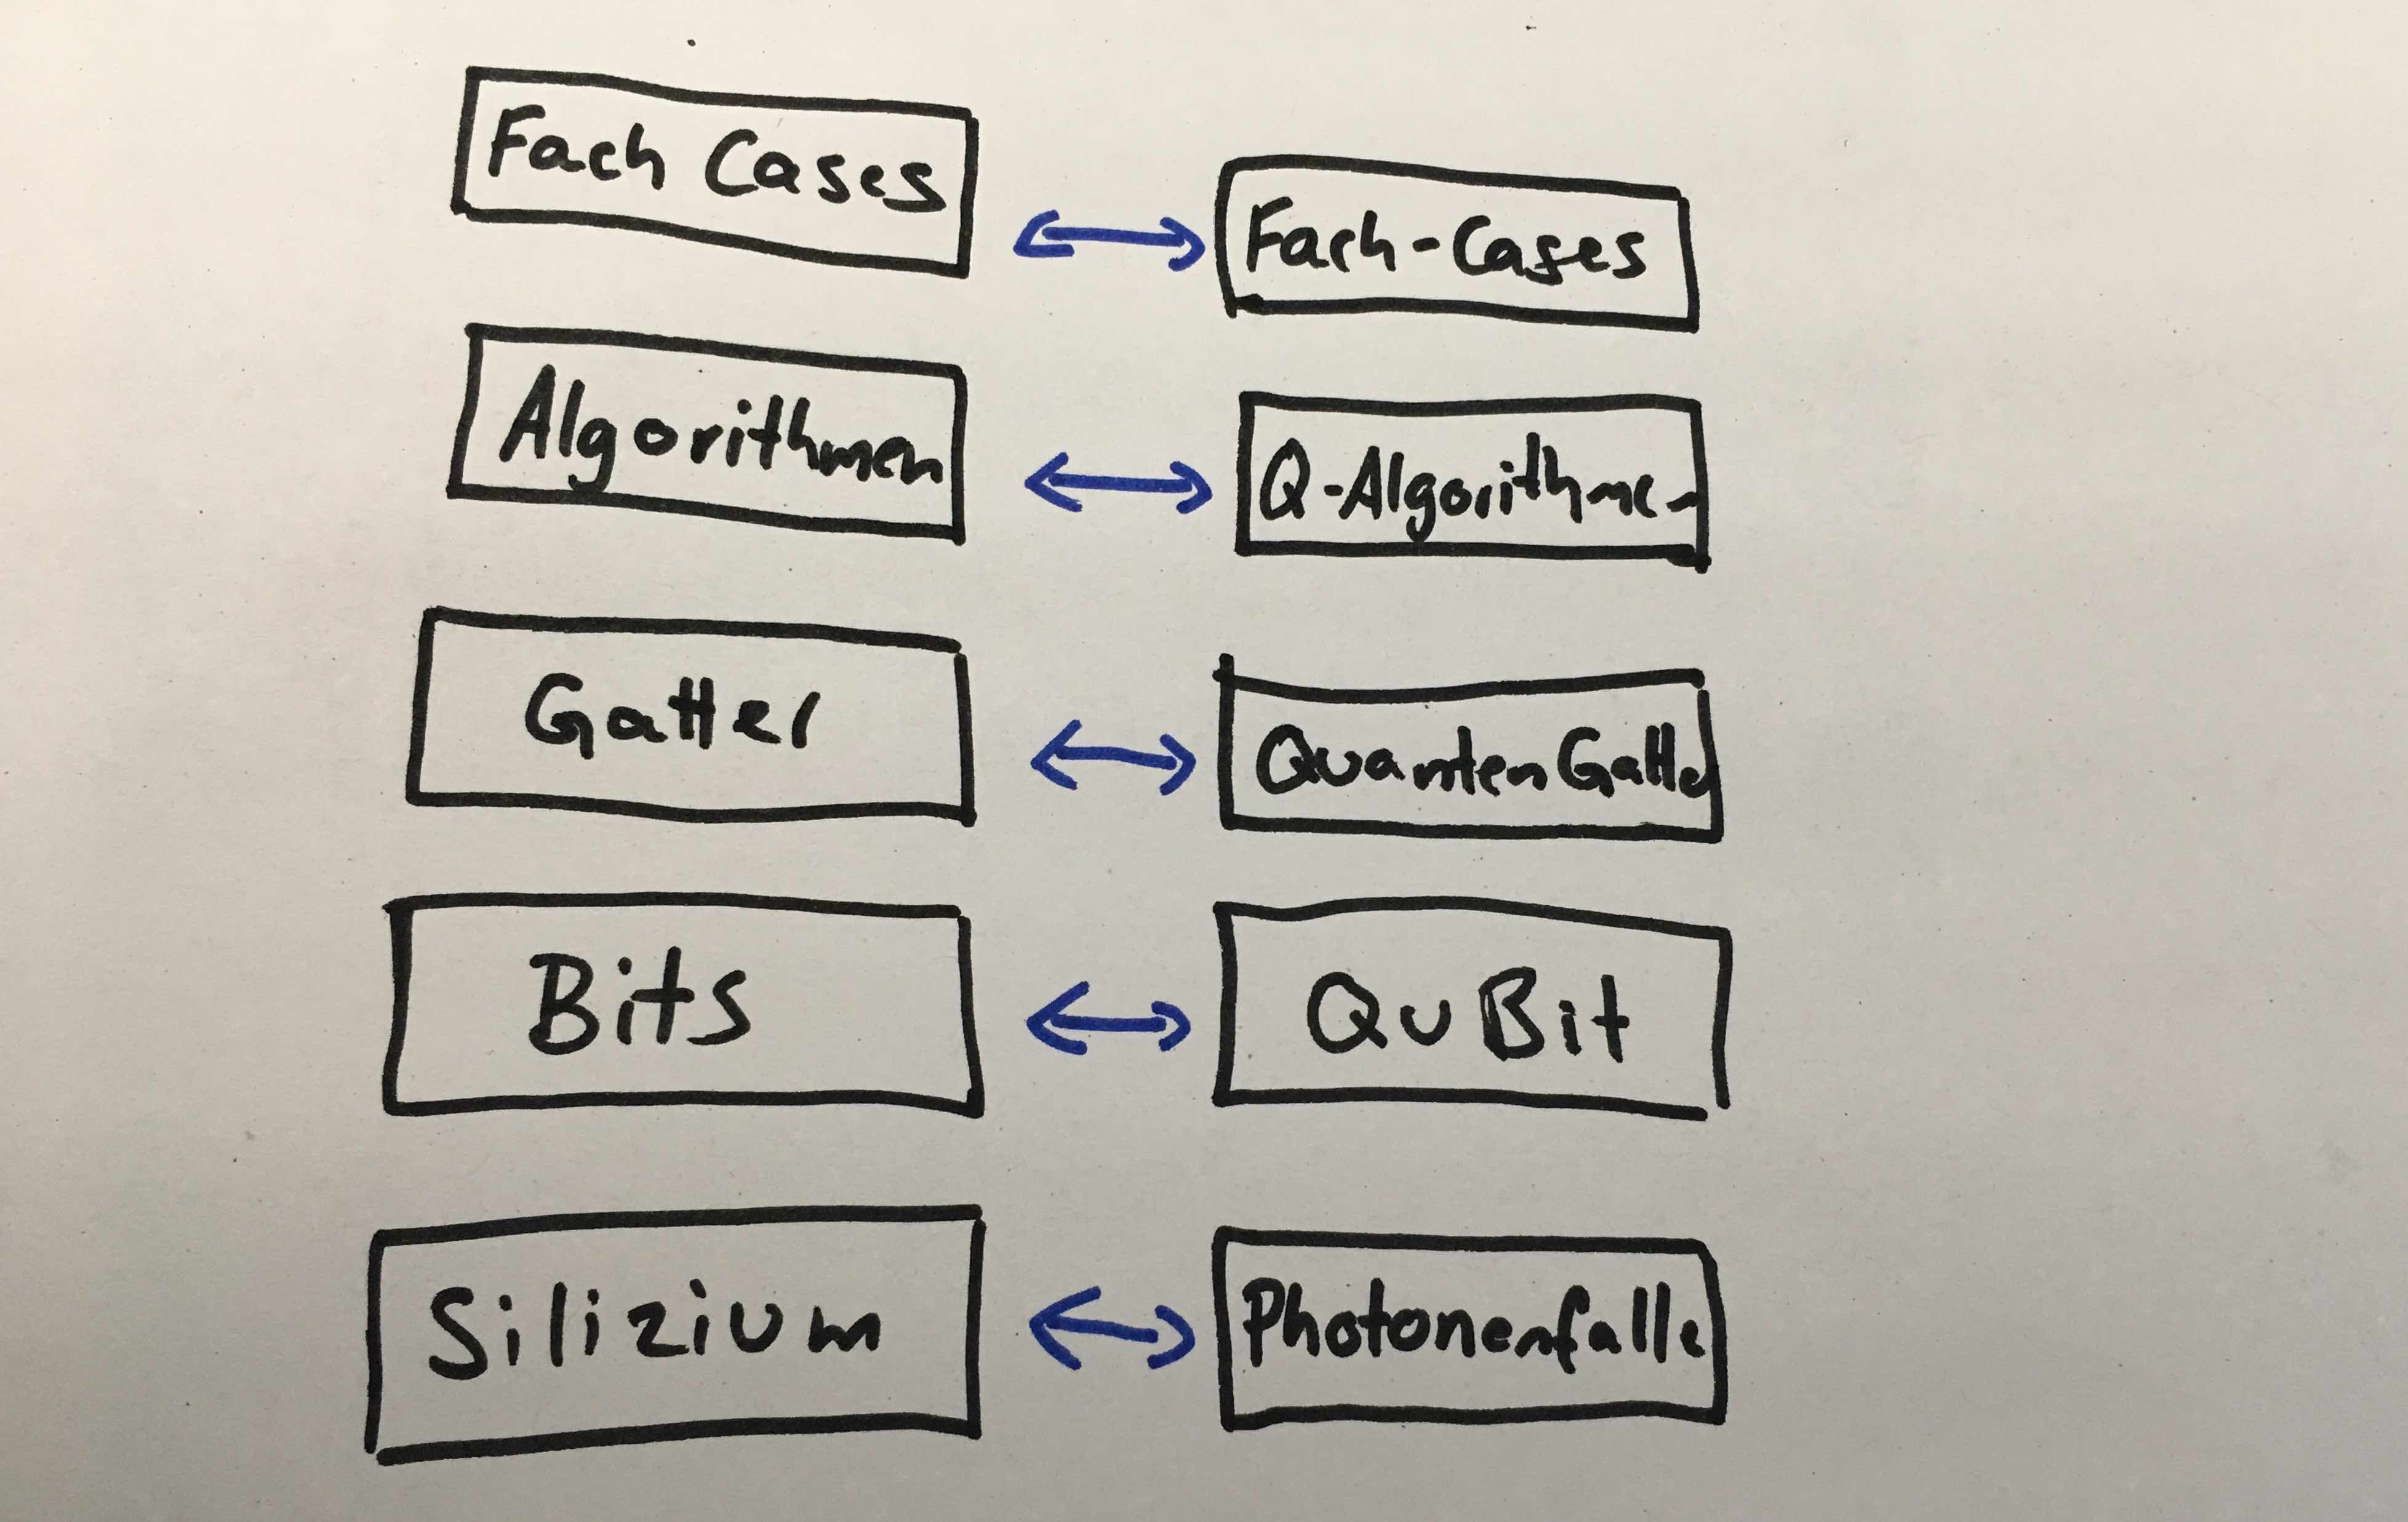

## Eine einfache Messung, welche ein Qubit auf ein klassisches Bit misst

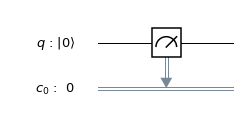

In [30]:
quantumcircuit = QuantumCircuit(1,1)
quantumcircuit.measure(0,0) #misst den qubit 0 auf den bit 0
quantumcircuit.draw(output='mpl')

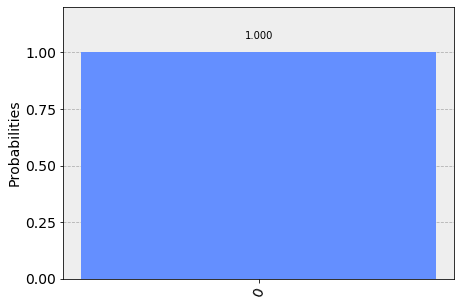

In [32]:
counts = execute(quantumcircuit, Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(counts)

## Jetzt drehen wir das Qubit, bzw. versetzen es in einen überlagerten Zustand

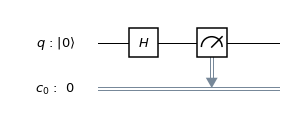

In [36]:
quantumcircuit = QuantumCircuit(1,1)
quantumcircuit.h(0) #Hadamard gate bewegt die z-Achse zur x-Achse und umgekehrt
#mquantumcircuit.h(0) #Hadamard gate
quantumcircuit.measure(0,0) #misst den qubit 0 auf den bit 0
quantumcircuit.draw(output='mpl')

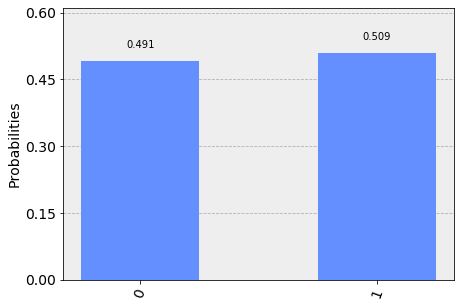

In [37]:
counts = execute(quantumcircuit, Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(counts)

## Man kann auch beliebige Gates einfügen

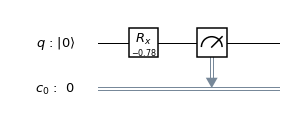

In [47]:
quantumcircuit = QuantumCircuit(1,1)
quantumcircuit.rx(-3.14/4,0)
quantumcircuit.measure(0,0)
quantumcircuit.draw(output='mpl')

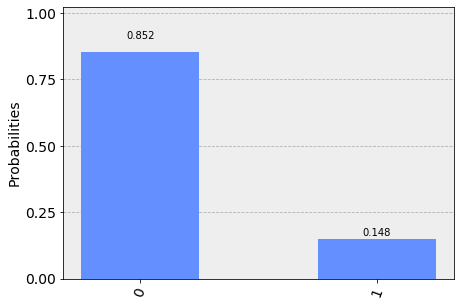

In [48]:
counts = execute(quantumcircuit, Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(counts)

In [8]:
from qiskit.visualization import plot_bloch_vector

## Die Bloch Sphere
Jeder Qubit Status kann als ein Punkt auf der Bloch-Sphere beschrieben werden.

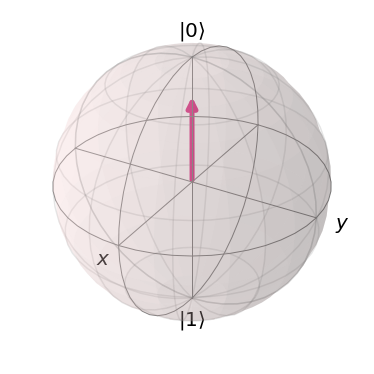

In [49]:
# z measurement of qubit 0
measure_z = QuantumCircuit(1,1)
measure_z.measure(0,0);

# x measurement of qubit 0
measure_x = QuantumCircuit(1,1)
measure_x.h(0)
measure_x.measure(0,0)

# y measurement of qubit 0
measure_y = QuantumCircuit(1,1)
measure_y.sdg(0)
measure_y.h(0)
measure_y.measure(0,0);

shots = 2**18 # number of samples used for statistics

bloch_vector = []
for measure_circuit in [measure_x, measure_y, measure_z]:
    
    # run the circuit with a the selected measurement and get the number of samples that output each bit value
    counts = execute(qc+measure_circuit,Aer.get_backend('qasm_simulator'),shots=shots).result().get_counts()

    # calculate the probabilities for each bit value
    probs = {}
    for output in ['0','1']:
        if output in counts:
            probs[output] = counts[output]/shots
        else:
            probs[output] = 0
            
    bloch_vector.append( probs['0'] -  probs['1'] )
    
plot_bloch_vector( bloch_vector )

## Verschränkung / Entanglement
Qubits können nicht kopiert werden, man kann sie aber verschränken

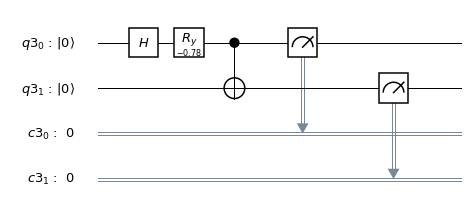

In [50]:
# Creating registers
q = QuantumRegister(2)
c = ClassicalRegister(2)

# quantum circuit to make an entangled bell state 
bell = QuantumCircuit(q, c)
bell.h(q[0])
bell.ry(-3.14/4,0) #do some tilt
bell.cx(q[0], q[1])
bell.measure(q[0], c[0])
bell.measure(q[1], c[1])

bell.draw(output='mpl')


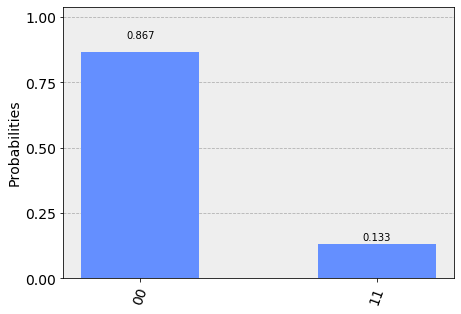

In [51]:
counts = execute(bell, Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(counts)

# Ein Algorithmus: Quantum Teleportation

In [12]:
# simple function that applies a series of unitary gates from a given string
def apply_secret_unitary(secret_unitary, qubit, quantum_circuit, dagger):
    functionmap = {
                    'x':quantum_circuit.x,
                    'y':quantum_circuit.y,
                    'z':quantum_circuit.z,
                    'h':quantum_circuit.h,                    
                    't':quantum_circuit.t,                    
    }
    if dagger: functionmap['t'] = quantum_circuit.tdg
    
    if dagger:
        [functionmap[unitary](qubit) for unitary in secret_unitary]
    else:
        [functionmap[unitary](qubit) for unitary in secret_unitary[::-1]]


In [13]:
secret_unitary = 'x'

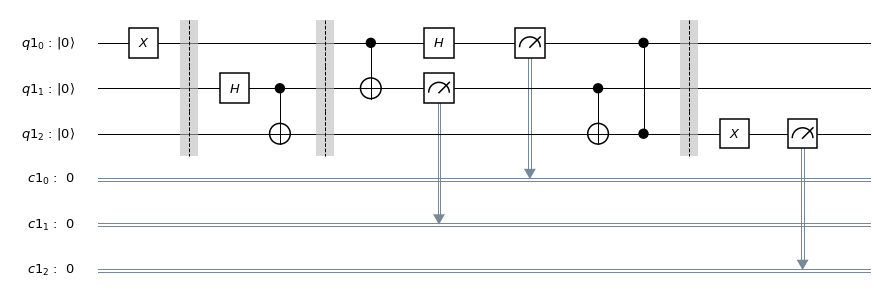

In [14]:
# Create the quantum circuit
q = QuantumRegister(3)
c = ClassicalRegister(3)
qc = QuantumCircuit(q, c)

''' Qubit ordering as follows (classical registers will just contain measured values of the corresponding qubits):
q[0]: qubit to be teleported (Alice's first qubit. It was given to her after the application of a secret unitary 
      which she doesn't know)
q[1]: Alice's second qubit
q[2]: Bob's qubit, which will be the destination for the teleportation
'''

# Apply the secret unitary that we are using to generate the state to teleport. You can change it to any unitary
apply_secret_unitary(secret_unitary, q[0], qc, dagger = 0)
qc.barrier()
# Next, generate the entangled pair between Alice and Bob (Remember: Hadamard followed by CX generates a Bell pair)
qc.h(q[1])
qc.cx(q[1], q[2])
qc.barrier()
# Next, apply the teleportation protocol. 
qc.cx(q[0], q[1])
qc.h(q[0])
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])
qc.cx(q[1], q[2])
qc.cz(q[0], q[2])
qc.barrier()

'''
In principle, if the teleportation protocol worked, we have q[2] = secret_unitary|0>
As a result, we should be able to recover q[2] = |0> by applying the reverse of secret_unitary
since for a unitary u, u^dagger u = I.
'''
apply_secret_unitary(secret_unitary, q[2], qc, dagger=1)
qc.measure(q[2], c[2])
qc.draw(output='mpl')

{'011': 272, '001': 225, '000': 253, '010': 274}


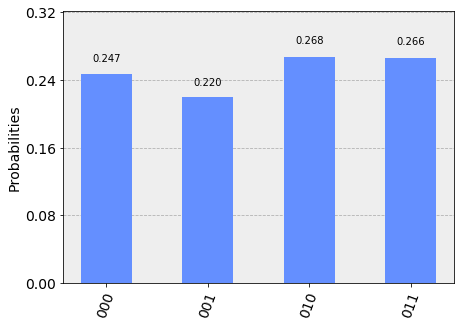

In [15]:
backend = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend, shots=1024)
sim_result = job_sim.result()

measurement_result = sim_result.get_counts(qc)
print(measurement_result)
plot_histogram(measurement_result)

# Ein Algorithmus: Suche mit Grover's Algorithmus

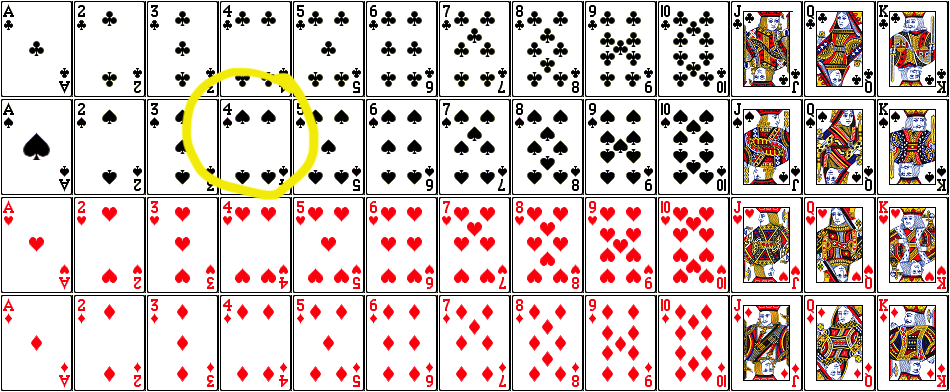

In [55]:
def phase_oracle(circuit, register):
    circuit.cz(qr[2],qr[0])
    #circuit.cz(qr[2],qr[1])

def n_controlled_Z(circuit, controls, target):
    """Implement a Z gate with multiple controls"""
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)
        
def inversion_about_average(circuit, register, n, barriers):
    """Apply inversion about the average step of Grover's algorithm."""
    circuit.h(register)
    circuit.x(register)
    
    if barriers:
        circuit.barrier()
    
    n_controlled_Z(circuit, [register[j] for j in range(n-1)], register[n-1])
    
    if barriers:
        circuit.barrier()
    
    circuit.x(register)
    circuit.h(register)

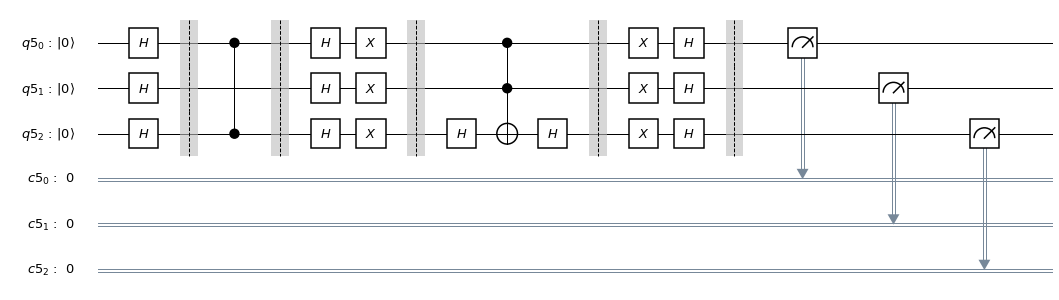

In [56]:
barriers = True

qr = QuantumRegister(3)
cr = ClassicalRegister(3)

groverCircuit = QuantumCircuit(qr,cr)
groverCircuit.h(qr)

if barriers:
    groverCircuit.barrier()

phase_oracle(groverCircuit, qr)

if barriers:
    groverCircuit.barrier()

inversion_about_average(groverCircuit, qr, 3, barriers)

if barriers:
    groverCircuit.barrier()

groverCircuit.measure(qr,cr)
groverCircuit.draw(output="mpl")

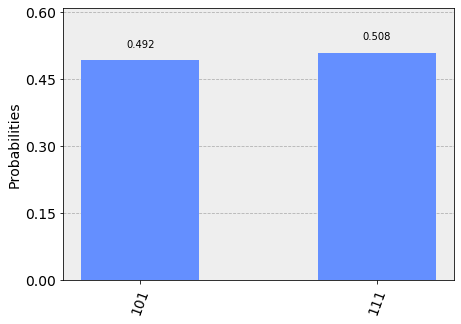

In [57]:
ckend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(groverCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

# Fachliches Beispiel